In [1]:
import pandas as pd
import csv
import matplotlib.pyplot as plt
import numpy as np

import scipy.optimize as optimization
from scipy.optimize import least_squares

In [2]:
#C:\ti\simplelink_cc13x2_26x2_sdk_4_40_04_04\tools\ble5stack\rtls_agent\examples\3ANT\ofoghi\rtls_aoa_iq_with_rtls_util_export_into_csv_3ant_AoA_log\04_16_2021_16_55_55_rtls_raw_iq_samples_0x11_zero_f88a5e2d7808_0.csv
# path = 'C:/ti/simplelink_cc13x2_26x2_sdk_4_40_04_04/tools/ble5stack/rtls_agent/examples/3ANT/ofoghi/rtls_aoa_iq_with_rtls_util_export_into_csv_3ant_AoA_log/04_16_2021_16_55_55_rtls_raw_iq_samples_0x11_zero_f88a5e2d7808_0.csv' # test @ 1m 
# path = 'C:/Users/pooneh/Documents/GitHub/AoA_IQsamples/AoA/DoA_Final/3_ANT/3ANT_AoA/datapoints_250cm/3ANT/zero_degree_zero_posi/05_18_2021_14_27_33_rtls_raw_iq_samples_f88a5e2d7808_0.csv'
path = 'C:/ti/simplelink_cc13x2_26x2_sdk_4_40_04_04/tools/ble5stack/rtls_agent/examples/3ANT/ofoghi/rtls_aoa_iq_with_rtls_util_export_into_csv_3ant_AoA_log/rtls_raw_iq_samples_0x10_30degreef88a5e2d7808_0.csv'

data = pd.read_csv(path)
data_size = len(data)
N = int(data_size/624)
print('Number of pakts are', N, int(N/2), len(data))
t = np.arange(0, 156*N, 0.25)
print(len(t))
data['time_stamp'] = t
data['Magnitude'] = np.sqrt(np.power(data['i'], 2) + np.power(data['q'], 2))

Number of pakts are 48 24 29952
29952


In [3]:
len(np.unique(data.channel))

24

In [4]:
data['ts'] = data['time_stamp']
t = data[data.channel >= 11]
t['omega'] = (t['channel']-11)*2+ 2428.25
tless = data[data.channel < 11]
tless['omega'] = (tless['channel'])*2 + 2404.25
data = t.append(tless)

<ipython-input-4-23b68b2b1de6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t['omega'] = (t['channel']-11)*2+ 2428.25
<ipython-input-4-23b68b2b1de6>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tless['omega'] = (tless['channel'])*2 + 2404.25


### NOW Optimize the RAW_IQ samples

In [43]:
# optomize the data from ANT1
def s(theta, t ):
    x = theta[0] * np.cos(2*np.pi*t*fc + phi)
    y = theta[1] * np.sin(2*np.pi*t*fc + phi)
    return np.array([x, y])

new_i_lst = []
new_q_lst = []

phi = 30

for i in range(0, len(data), 624):
    Ai = data.Magnitude[i:i+624].mean()
    Aq = data.Magnitude[i:i+624].mean()
    fc = data.omega[i:i+624].mean(); 
    ts = data.time_stamp[i:i+624]
    ss = s([Ai, Aq, fc, phi], ts)
    ss[0] += data['i'][i:i+624]
    ss[1] += data['q'][i:i+624]
    

    def fun(theta):
        return (ss- s(theta, ts)).flatten()

    theta0 = [0,0,0,0]
    res1 = least_squares(fun, theta0)
    N = int(len(res1.fun)/2)
    new_i1 = res1.fun[0:N]
    new_i_lst.append(new_i1)
    new_q1 = res1.fun[N:len(res1.fun)]
    new_q_lst.append(new_q1)
print('Its finished')

Its finished


In [44]:
# plt.scatter(data['i'][0:624], data['q'][0:624])
# plt.scatter(new_i_lst[0], new_q_lst[0])

In [45]:
from itertools import chain
flatten_i = list(chain.from_iterable(new_i_lst))
flatten_q = list(chain.from_iterable(new_q_lst))
data['new_i'] = flatten_i
data['new_q'] = flatten_q

In [46]:
info =[]
data_size = len(data)
N = int(data_size/624)
for n in range(N):
    for i in range(36+n*624, 624*(n+1), 8):
        for j in range(i, i+4):
            info.append({"pkt": n, "Channel": data['channel'][j], "sample_idx": data['sample_idx'][j], 
                         "I": data['i'][j],
                         "Q":data['q'][j],
                         "Magnitude": data['Magnitude'][j],
                         "time_stamp": data['time_stamp'][j], "omega": data['omega'][j], 
                          "new_i": data['new_i'][j], "new_q": data['new_q'][j]})
    info_dec = pd.DataFrame(info)
print('finished', N)

finished 48


In [47]:
df = info_dec.drop(info_dec[info_dec.sample_idx > 607].index)

In [48]:
lst_ant1 = []
lst_ant2 = []
lst_ant3 = []

for i in range(0, len(df), 12):    
    lst_ant2.append(df[i:i+4])
    lst_ant1.append(df[i+4:i+8])
    lst_ant3.append(df[i+8:i+12])

In [49]:
df_ant1 = pd.concat(lst_ant1,  ignore_index=True)
df_ant2 = pd.concat(lst_ant2,  ignore_index=True)
df_ant3 = pd.concat(lst_ant3,  ignore_index=True)

### Caluclate the phase difference 

In [50]:
X12 = (df_ant1['I'] + 1j*df_ant1['Q']) * (df_ant2['I'] - 1j*df_ant2['Q'])
X23 = (df_ant2['I'] + 1j*df_ant2['Q']) * (df_ant3['I'] - 1j*df_ant3['Q'])
X13 = (df_ant1['I'] + 1j*df_ant1['Q']) * (df_ant3['I'] - 1j*df_ant3['Q'])
X12_opt = (df_ant1['new_i'] + 1j*df_ant1['new_q']) * (df_ant2['new_i'] - 1j*df_ant2['new_q'])
X23_opt = (df_ant2['new_i'] + 1j*df_ant2['new_q']) * (df_ant3['new_i'] - 1j*df_ant3['new_q'])
X13_opt = (df_ant1['new_i'] + 1j*df_ant1['new_q']) * (df_ant3['new_i'] - 1j*df_ant3['new_q'])


In [51]:
d = {'channel': df_ant1['Channel'],'omega':df_ant1['omega']}
data_fin = pd.DataFrame(data=d)
data_fin['phi12'] = np.angle(X12)
data_fin['phi23'] = np.angle(X23)
data_fin['phi13'] = np.angle(X13)
data_fin['mag12'] = np.abs(X12)
data_fin['mag23'] = np.abs(X23)
data_fin['mag13'] = np.abs(X13)

In [52]:
data_fin['phi12_opt'] = np.angle(X12_opt)
data_fin['phi23_opt'] = np.angle(X23_opt)
data_fin['phi13_opt'] = np.angle(X13_opt)
data_fin['mag12_opt'] = np.abs(X12_opt)
data_fin['mag23_opt'] = np.abs(X23_opt)
data_fin['mag13_opt'] = np.abs(X13_opt)

In [53]:
phi_channel = []
for i in range(0, len(data_fin),96):
    phi_channel.append({"channel":data_fin['channel'][i], "omega":data_fin['omega'][i],
                       "ave_phi12": np.average(data_fin['phi12'][i:i+96]),
                       "ave_phi23": np.average(data_fin['phi23'][i:i+96]),
                        "ave_phi13": np.average(data_fin['phi13'][i:i+96]),
                        "ave_phi12_opt": np.average(data_fin['phi12_opt'][i:i+96]),
                       "ave_phi23_opt": np.average(data_fin['phi23_opt'][i:i+96]),
                        "ave_phi13_opt": np.average(data_fin['phi13_opt'][i:i+96]),
                       "ave_mag12": np.average(data_fin['mag12'][i:i+96]),
                       "ave_mag23": np.average(data_fin['mag23'][i:i+96]),
                       "ave_mag13": np.average(data_fin['mag13'][i:i+96]),})
average_perchannel = pd.DataFrame(phi_channel)
print('finished', len(data_fin))

finished 4608


In [54]:
ave_phi12 = np.average(average_perchannel['ave_phi12'])*180/np.pi
ave_phi23 = np.average(average_perchannel['ave_phi23'])*180/np.pi,
ave_phi13 = np.average(average_perchannel['ave_phi13'])*180/np.pi
total_ave = (ave_phi12+ ave_phi23 + ave_phi13)/3

In [55]:
ave_phi12_opt = np.average(average_perchannel['ave_phi12_opt'])*180/np.pi
ave_phi23_opt = np.average(average_perchannel['ave_phi23_opt'])*180/np.pi,
ave_phi13_opt = np.average(average_perchannel['ave_phi13_opt'])*180/np.pi
total_ave_opt = (ave_phi12_opt+ ave_phi23_opt + ave_phi13_opt)/3

In [56]:
ave_phi12_opt_rad = np.average(average_perchannel['ave_phi12_opt'])
ave_phi23_opt_rad = np.average(average_perchannel['ave_phi23_opt'])
ave_phi13_opt_rad = np.average(average_perchannel['ave_phi13_opt'])
total_ave_opt_rad = (ave_phi12_opt_rad+ ave_phi23_opt_rad + ave_phi13_opt_rad)/3

In [57]:
print(' Angle per paire', ave_phi12, ave_phi23, ave_phi13, '\n Total average of angle', total_ave)

 Angle per paire -54.88701509438584 (-3.5920443826872632,) 57.38031552292689 
 Total average of angle [-0.36624798]


In [58]:
print(' Angle per paire', ave_phi12_opt_rad, ave_phi23_opt_rad, ave_phi13_opt_rad, '\n Total average of angle', total_ave_opt_rad)

 Angle per paire -0.9981301201369237 -0.060669151598520134 0.9810542915329289 
 Total average of angle -0.025914993400838287


In [59]:
print(' Angle per paire OPTIMIZED', ave_phi12_opt, ave_phi23_opt, ave_phi13_opt, '\n Total average of angle_opt', total_ave_opt)

 Angle per paire OPTIMIZED -57.188643288731555 (-3.476086333234576,) 56.210270378033876 
 Total average of angle_opt [-1.48481975]


array([<AxesSubplot:>], dtype=object)

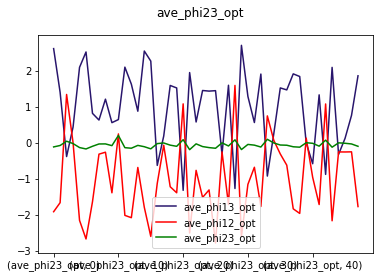

In [60]:
average_perchannel.unstack(level=0)[['ave_phi13_opt']].plot(subplots=True, title="ave_phi13_opt", color= '#28156c', label='ave_phi13_opt', legend=True)
average_perchannel.unstack(level=0)[['ave_phi12_opt']].plot(subplots=True, title="ave_phi12_opt", color= 'r', label='ave_phi12_opt', legend=True)
average_perchannel.unstack(level=0)[['ave_phi23_opt']].plot(subplots=True, title="ave_phi23_opt", color= 'g', label='ave_phi23_opt', legend=True)

### Import the correction file

In [61]:
path_coeff = 'C:/Users/pooneh/Documents/GitHub/AoA_IQsamples/AoA/DoA_Final/3_ANT/3ANT_AoA/datapoints_250cm/3ANT/zerocorrection_coeff_negative.csv'

df_corr = pd.read_csv(path_coeff)
# expected_angel = df_corr.ex_phi12.mean()*180/np.pi

In [62]:
np.where(df_corr.channel==16)

(array([20, 36, 55, 72], dtype=int64),)

In [63]:
channl = average_perchannel.channel
phi12_corr_ave = []
phi23_corr_ave = []
phi13_corr_ave = []
phi12_corr_ave_opt = []
phi23_corr_ave_opt = []
phi13_corr_ave_opt = []
# phi12_ave = []
for ch in channl:
    g = df_corr[df_corr.channel == ch]
    f = average_perchannel[average_perchannel.channel == ch]
#     print('g is:',g,'and ch is',ch,'\n -------------- f is', f)
    phi12_corr_ave.append(np.average(f.ave_phi12)- np.average(g.phi12_correction))
    phi23_corr_ave.append(np.average(f.ave_phi23)- np.average(g.phi23_correction))
    phi13_corr_ave.append(np.average(f.ave_phi13)- np.average(g.phi13_correction))
    phi12_corr_ave_opt.append(np.average(f.ave_phi12_opt)- np.average(g.phi12_correction))
    phi23_corr_ave_opt.append(np.average(f.ave_phi23_opt)- np.average(g.phi23_correction))
    phi13_corr_ave_opt.append(np.average(f.ave_phi13_opt)- np.average(g.phi13_correction))
#     phi12_ave.append(np.average(g.phi12_correction)*180/np.pi)
#     print(np.average(g.phi12_correction)*180/np.pi)


# print(len(average_perchannel), np.average(phi12_ave))
average_perchannel['corrected_phi12'] = phi12_corr_ave
average_perchannel['corrected_phi23'] = phi23_corr_ave
average_perchannel['corrected_phi13'] = phi13_corr_ave
average_perchannel['corrected_phi12_opt'] = phi12_corr_ave_opt
average_perchannel['corrected_phi23_opt'] = phi23_corr_ave_opt
average_perchannel['corrected_phi13_opt'] = phi13_corr_ave_opt


C:\Users\pooneh\AppData\Local\Continuum\anaconda3\envs\py3\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\pooneh\AppData\Local\Continuum\anaconda3\envs\py3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\pooneh\AppData\Local\Continuum\anaconda3\envs\py3\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\pooneh\AppData\Local\Continuum\anaconda3\envs\py3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\pooneh\AppData\Local\Continuum\anaconda3\envs\py3\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\pooneh\AppData\Local\Continuum\anaconda3\envs\py3\lib\site-packages\numpy\core\_method

In [64]:
np.isnan(phi12_corr_ave)

array([False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False])

In [65]:
np.unique(channl), np.unique(df_corr.channel)

(array([ 0,  1,  3,  4,  6,  8, 10, 11, 13, 15, 17, 18, 20, 22, 23, 24, 26,
        27, 29, 30, 31, 33, 34, 36], dtype=int64),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35], dtype=int64))

In [66]:
np.where(df_corr.channel ==21)

(array([33, 50, 66], dtype=int64),)

In [67]:
average_perchannel = average_perchannel.dropna()

## Calculate the expected angle

In [68]:
real_phi= 45-30
cos = np.cos(np.deg2rad(real_phi))
landa = 2.9e8/(average_perchannel.omega*1e6)
d12 = 3.5e-2
ex_phi12 = (cos* 2*np.pi*d12)/landa
expected_angel = ex_phi12.mean()*180/np.pi
expected_angel

102.5052144583449

In [69]:
df_corr

,phi12_correction,phi23_correction,phi13_correction,channel,omega,ex_phi12
0,1.455368,-0.731970,-5.428888,3,2410.25,1.292400
1,0.996731,0.072995,-5.213460,18,2442.25,1.309559
2,0.773752,0.309305,-5.200128,29,2464.25,1.321356
3,1.357138,-0.827152,-1.826209,7,2418.25,1.296690
4,0.918690,0.028325,-5.205271,14,2434.25,1.305269
...,...,...,...,...,...,...
68,1.419414,-0.577798,-5.179769,10,2424.25,1.299907
69,1.070892,-0.193945,-5.406238,27,2460.25,1.319211
70,1.335983,-0.810597,-2.354408,1,2406.25,1.290255
71,1.405881,-0.042292,-4.919596,12,2430.25,1.303124


In [70]:
phi12_corr = df_corr.phi12_correction.mean()
phi23_corr = df_corr.phi23_correction.mean()
phi13_corr = df_corr.phi13_correction.mean()

In [71]:
print(phi12_corr , phi23_corr , phi13_corr, ex_phi12.mean() )

1.091607562337972 -0.3659162613312059 -4.652851601072335 1.7890534927610142


In [72]:
len(np.unique(df_corr.channel)), len(np.unique(average_perchannel.channel))

(36, 23)

In [73]:
np.unique(df_corr.channel), np.unique(average_perchannel.channel)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35], dtype=int64),
 array([ 0,  1,  3,  4,  6,  8, 10, 11, 13, 15, 17, 18, 20, 22, 23, 24, 26,
        27, 29, 30, 31, 33, 34], dtype=int64))

In [74]:
# average_perchannel['corrected_phi12_v2'] = average_perchannel.ave_phi12.mean() - phi12_corr
# average_perchannel['corrected_phi23_v2'] = average_perchannel.ave_phi23.mean() - phi23_corr
# average_perchannel['corrected_phi13_v2'] = average_perchannel.ave_phi13.mean() - phi13_corr

In [75]:
ave_phi12_corr = np.average(average_perchannel['corrected_phi12'])*180/np.pi
ave_phi23_corr = np.average(average_perchannel['corrected_phi23'])*180/np.pi,
ave_phi13_corr = np.average(average_perchannel['corrected_phi13'])*180/np.pi
total_ave_corr = (ave_phi12_corr+ ave_phi23_corr + ave_phi13_corr)/3

In [76]:
# ave_phi12_corr_no_nan = np.average(average_perchannel_no_nan['corrected_phi12'])*180/np.pi
# ave_phi23_corr_no_nan = np.average(average_perchannel_no_nan['corrected_phi23'])*180/np.pi,
# ave_phi13_corr_no_nan = np.average(average_perchannel_no_nan['corrected_phi13'])*180/np.pi
# total_ave_corr_no_nan = (ave_phi12_corr_no_nan+ ave_phi23_corr_no_nan + ave_phi13_corr_no_nan)/3

In [77]:
print(' Angle per paire_corrected', ave_phi12_corr, ave_phi23_corr, ave_phi13_corr, '\n Total average of angle_corrected', total_ave_corr)

 Angle per paire_corrected -113.15425278247425 (12.327481858448154,) 322.65934018708504 
 Total average of angle_corrected [73.94418975]


In [78]:
# print(' Angle per paire_corrected_no_nan', ave_phi12_corr_no_nan, ave_phi23_corr_no_nan, ave_phi13_corr_no_nan, '\n Total average of angle_corrected_no_nan', total_ave_corr_no_nan)

In [79]:
error = total_ave_corr - expected_angel
# error_no_nan = total_ave_corr_no_nan - expected_angel
print('error is', error)

error is [-28.5610247]


### Kalman Filter
has error

In [80]:
sdata = average_perchannel

In [81]:
len(np.unique(sdata.channel))

23

In [82]:
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise

In [83]:
t = 2.5e-8
error_est_x = -0.2272
error_est_x23 = -0.3128
error_est_x13 = -0.178
# print(error_est_x, error_est_x23, error_est_x13)
error_est_v = 5;
v = 2404
def prediction2d(x, v, t):
    A = np.array([[1, t],
                  [0, 1]])
    X = np.array([[x],
                  [v]])
    X_prime = A.dot(X) 
    return X_prime

def covariance2d(sigma1, sigma2):
    cov1_2 = sigma1 * sigma2
    cov2_1 = sigma2 * sigma1
    cov_matrix = np.array([[sigma1 ** 2, cov1_2],
                           [cov2_1, sigma2 ** 2]])
    return np.diag(np.diag(cov_matrix))

# Initial Estimation Covariance Matrix
P = covariance2d(error_est_x, error_est_v)
P23 = covariance2d(error_est_x23, error_est_v)
P13 = covariance2d(error_est_x13, error_est_v)

A = np.array([[1, t],
              [0, 1]])

error_obs_v = int(sdata['omega'].std())

error_obs_x = 0.328
error_obs_x23 = 0.467
error_obs_x13 = 0.2695

x_observations = sdata['corrected_phi12']
x23_observations = sdata['corrected_phi23']
x13_observations = sdata['corrected_phi13']
# x_observations = sdata['ave_phi12']
# x23_observations = sdata['ave_phi12']
# x13_observations = sdata['ave_phi12']

v_observations = sdata['omega']
v = sdata['omega'].mean()
z = np.c_[x_observations, v_observations]
z23 = np.c_[x23_observations, v_observations]
z13 = np.c_[x13_observations, v_observations]

# Initial State Matrix
X = np.array([[z[0][0]],
              [v]])
X23 = np.array([[z23[0][0]],
              [v]])
X13 = np.array([[z13[0][0]],
              [v]])

n = len(z[0])

In [84]:
results = []
for i in range(len(z)):
    for data in z[1:]:
        X = prediction2d(X[0][0], X[1][0], t)
        # To simplify the problem, professor
        # set off-diagonal terms to 0.
        P = np.diag(np.diag(A.dot(P).dot(A.T)))

        # Calculating the Kalman Gain
        H = np.identity(n)
        R = covariance2d(error_obs_x, error_obs_v)
        S = H.dot(P).dot(H.T) + R
        from numpy.linalg import inv
        K = P.dot(H).dot(inv(S))
        del inv

        # Reshape the new data into the measurement space.
        Y = H.dot(data).reshape(n, -1)

        # Update the State Matrix
        # Combination of the predicted state, measured values, covariance matrix and Kalman Gain
        X = X + K.dot(Y - H.dot(X))
        
        # Update Process Covariance Matrix
        P = (np.identity(len(K)) - K.dot(H)).dot(P)
    results.append(X)


In [85]:
results = []
for i in range(len(z23)):
    for data in z23[1:]:
        X23 = prediction2d(X23[0][0], X23[1][0], t)
        # To simplify the problem, professor
        # set off-diagonal terms to 0.
        P23 = np.diag(np.diag(A.dot(P23).dot(A.T)))

        # Calculating the Kalman Gain
        H = np.identity(n)
        R = covariance2d(error_obs_x23, error_obs_v)
        S = H.dot(P23).dot(H.T) + R
        from numpy.linalg import inv
        K = P23.dot(H).dot(inv(S))
        del inv

        # Reshape the new data into the measurement space.
        Y = H.dot(data).reshape(n, -1)

        # Update the State Matrix
        # Combination of the predicted state, measured values, covariance matrix and Kalman Gain
        X23 = X23 + K.dot(Y - H.dot(X23))
        
        # Update Process Covariance Matrix
        P = (np.identity(len(K)) - K.dot(H)).dot(P)
    results.append(X23)

In [86]:
results = []
for i in range(len(z13)):
    for data in z13[1:]:
        X13 = prediction2d(X13[0][0], X13[1][0], t)
        # To simplify the problem, professor
        # set off-diagonal terms to 0.
        P13 = np.diag(np.diag(A.dot(P13).dot(A.T)))

        # Calculating the Kalman Gain
        H = np.identity(n)
        R = covariance2d(error_obs_x13, error_obs_v)
        S = H.dot(P13).dot(H.T) + R
        from numpy.linalg import inv
        K = P13.dot(H).dot(inv(S))
        del inv

        # Reshape the new data into the measurement space.
        Y = H.dot(data).reshape(n, -1)

        # Update the State Matrix
        # Combination of the predicted state, measured values, covariance matrix and Kalman Gain
        X13 = X13 + K.dot(Y - H.dot(X13))
        
        # Update Process Covariance Matrix
        P = (np.identity(len(K)) - K.dot(H)).dot(P)
    results.append(X13)

In [87]:
kalman_filter_error = expected_angel - (X[0]+X23[0]+X13[0])/3*180/np.pi
print(kalman_filter_error)

[22.25938412]


In [88]:
print('kalman filter angle', (X[0]+X23[0]+X13[0])/3*180/np.pi, 'expected angle',expected_angel) 

kalman filter angle [80.24583034] expected angle 102.5052144583449


In [89]:
no_correction_error = expected_angel - (np.average(average_perchannel['ave_phi12'])*180/np.pi+ np.average(average_perchannel['ave_phi23'])*180/np.pi+ np.average(average_perchannel['ave_phi13'])*90/np.pi)/3
no_correction_error_opt = expected_angel - (np.average(average_perchannel['ave_phi12_opt'])*180/np.pi+ np.average(average_perchannel['ave_phi23_opt'])*180/np.pi+ np.average(average_perchannel['ave_phi13_opt'])*90/np.pi)/3
correction_error = expected_angel - total_ave_corr

### Compare the errors

In [90]:
print(' No_correction_error:', no_correction_error , 
     '\n No__correction_error_opt:', no_correction_error_opt,
     '\n corrected error', correction_error,
     '\n kalman_filter_error(opt):' , kalman_filter_error)

 No_correction_error: 111.12875546169705 
 No__correction_error_opt: 112.08610918376691 
 corrected error [28.5610247] 
 kalman_filter_error(opt): [22.25938412]


In [91]:
error_decrease = abs(no_correction_error-kalman_filter_error)*100/abs(no_correction_error)
print('The percentage of error decrease, using kalamn filter is:', error_decrease, '%')

The percentage of error decrease, using kalamn filter is: [79.96973508] %


In [92]:
deltaphi_kf =  (X[0]+X23[0]+X13[0])/3
cte = np.average(landa/(2*np.pi*d12))
theta = np.arccos(X[0]*cte)

<ipython-input-92-6414f6fcb26e>:3: RuntimeWarning: invalid value encountered in arccos
  theta = np.arccos(X[0]*cte)


In [93]:
# argument1 = (X[0]-np.pi/4)*cte,
# argument2 = (X23[0]-np.pi/4)*cte,
# argument3 = (X13[0]-np.pi/4-np.pi)*cte
argument1 = (X[0])*cte,
argument2 = (X23[0])*cte,
argument3 = (X13[0]-np.pi)*cte
print(argument1, argument2, argument3)

(array([-1.04664127]),) (array([0.05082134]),) [1.56820579]


In [94]:
theta1 = np.arccos(argument1)*180/np.pi
theta2 = np.arccos(argument2)*180/np.pi
theta3 = np.arccos(argument3)*180/np.pi
theta_ave = (theta1+ theta2 + theta3)/3
print(theta1, theta2 , theta3)
print(theta_ave)

[[nan]] [[87.0868969]] [nan]
[[nan]]


<ipython-input-94-a844a6cfd62e>:1: RuntimeWarning: invalid value encountered in arccos
  theta1 = np.arccos(argument1)*180/np.pi
<ipython-input-94-a844a6cfd62e>:3: RuntimeWarning: invalid value encountered in arccos
  theta3 = np.arccos(argument3)*180/np.pi


In [95]:
average_theta  = (theta*180/np.pi+ np.arccos(X23[0]*cte)*180/np.pi+ np.arccos((X13[0]-np.pi)*cte/2)*180/np.pi)/3

In [116]:
print(' average theta: ', average_theta-45, '\n real_thetea', real_phi)

 average theta:  [nan] 
 real_thetea 15


In [117]:
print(' average theta: ', theta_ave-45, '\n real_thetea', real_phi)

 average theta:  [[nan]] 
 real_thetea 15
